# Kaggle Product Failure  
By Joshua Mayes - 08/18/2022

In [34]:
# Core DS libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

import mytk # My Toolkit
import wrangle # Helper functions

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score


In [20]:
pd.options.display.max_columns = None
train, test, validate = wrangle.wrangle_potatoes()

In [21]:
# Load and impute null values for the kaggle submission data
final = pd.read_csv('./data/test.csv')
imputeCols = train.select_dtypes(include=np.number).drop(columns='failure').columns.tolist()
imputer =  SimpleImputer()
imputer.fit(train[imputeCols])
final[imputeCols] = imputer.transform(final[imputeCols])

## Findings

### The failure rate varies slightly across different product codes.

<AxesSubplot:xlabel='product_code', ylabel='failure'>

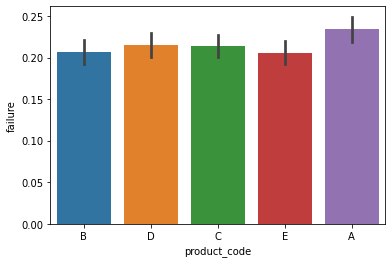

In [22]:
# Show the failure rate across product codes
sns.barplot(data=train, x='product_code', y='failure')

In all of my exploration this seemed to be the single most powerful predictor of failure.  
However, the product codes don't match the dataset we will be predicting on

In [23]:
# Show the product codes available in the final dataset
final.product_code.value_counts()

F    5422
I    5228
G    5107
H    5018
Name: product_code, dtype: int64

So we cannot use that as a predictor.

<div style="background-color: #f44336; color: white; border-radius: 25px; padding: 15px; width: 55%">
 <strong>Warning!</strong>

  A model only performs well for the world in which it was trained.  Since the product codes available for training are different than those that can be predicted on, there is not a reasonable expectation for a good model performance.
</div>

### When examining each product separately, measurement_2 is the only feature that has predictive power over failure.

In [24]:
# Use my toolkit to quickly identify category columns stored as integers
gotchas = mytk.get_gotchas(train)
override_cat = gotchas['probable_categories']

# Function that splits the data by product code and deploys statistical tests
def failure_stats_for_each_prod(df):
    prod = {}
    for code in df.product_code.unique().tolist():
        prod[code] =  df[df.product_code == code].copy()
    results = {}
    for k, v in prod.items():
        results[k] = mytk.pop_unrejected(mytk.all_the_stats(v, override_categorical=override_cat))['failure']
    # Then prints it in json format
    print(mytk.prettify(results))

# failure_stats_for_each_prod(train)

For products "B" and "D" `measurement_2` seems to be a statistically significant predictor of failure.

### RFE (Recursive Feature Elimination) reveals some other strong predictors

Before I can use RFE, however, I need to temporarily encode my categorical variables

In [25]:
def encode_variables(df):
    catCols = ['product_code','attribute_0','attribute_1','attribute_2','attribute_3']
    for col in catCols:
        df[col] = df[col].astype('category').cat.codes
    return df
# Encode categoricals
train_encoded = encode_variables(train)

In [26]:
# Use RFE to get the best 3 features
estimator = RandomForestClassifier(max_depth=5)
selector = RFE(estimator=estimator, n_features_to_select=3 )
selector.fit(train_encoded.drop(columns='failure'), train_encoded.failure)
selector.get_feature_names_out()

array(['loading', 'measurement_5', 'measurement_17'], dtype=object)

In [27]:
feats = ['loading', 'measurement_2','measurement_5', 'measurement_17' ] 
target = 'failure'

## Modeling

### Modeling X/y prepartion

In [28]:
# Train X/y
tx = train[feats]
ty = train.failure

# Test X/y
sx = test[feats]
sy = test.failure

# Validate X/y
vx = validate[feats]
vy = validate.failure

# Final X. y not available
fx = final[feats]

### Baseline Model

I can use my custom baseline model class to quickly create some baseline metrics.  However, since we are using Area Under Curve metrics we can already tell that the AUC score will be 0.50.  This is because as the confidence threshold moves, what our predictions will be does not.

In [29]:
# Create a new instance of my BaselineModel class, setting the aggregation function to 'mode'
baseline = mytk.BaselineModel(method='mode')
baseline.fit(train.failure)
baseline.baseline, baseline.baseline_proba

(0.0, 0.7849705181282148)

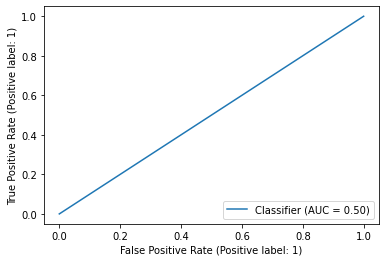

In [30]:
RocCurveDisplay.from_predictions(ty, baseline.predict_proba(ty))

### Random Forest model

<AxesSubplot:>

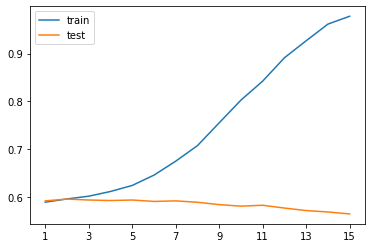

In [32]:
mets = {}
for i in range (1, 16):
    rfc = RandomForestClassifier(max_depth=i)
    rfc.fit(tx, ty)
    tp = rfc.predict_proba(tx)[:, 1]
    sp = rfc.predict_proba(sx)[:, 1]
    mets[f'{i}'] = {'train': roc_auc_score(ty, tp),
                            'test': roc_auc_score(sy, sp)}
rfc_aoc = pd.DataFrame.from_dict(mets, 'index')
rfc_aoc.plot()

In [33]:
rfc_aoc.T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
train,0.589596,0.596350,0.602085,0.611936,0.624542,0.646079,0.675236,0.707747,0.755349,0.802807,0.842448,0.891212,0.926779,0.961533,0.977951
test,0.592346,0.596067,0.594092,0.592999,0.594069,0.591141,0.592295,0.589353,0.584480,0.581249,0.583132,0.577280,0.572029,0.569077,0.565047


### Random Forest model

# Conclusion

This project was doomed from the start.  The differences between the training data and the data kaggle wants us to predict rendered findings from exploration useless.

Although the models I created performed better than baseline for the data from the training dataset, I cannot be confident that the model will perform anywhere near that level.